# Utils functions

In [1]:
import skimage.io
def load_image(image_path):
    """
    Load image with its path
    """
    return skimage.io.imread(image_path)

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
def show_image(img):
    """
    Show a single image
    """
    fig = plt.figure(figsize = (15,10))
    plt.imshow(img)

In [3]:
from skimage.measure import label, regionprops

def create_rectangles_from_heatmap(heatmap):
    label_image = label(heatmap)
    rects = []
    
    for i, region in enumerate(regionprops(label_image)):
        bbox = region.bbox
        rect = ((bbox[1], bbox[0]), (bbox[3], bbox[2]))
        
        rects.append(rect)

    return rects

In [4]:
import numpy as np
def create_mark(rectangles, shape): # [((begin_i, begin_j), (end_i, end_j)), ...]
    """
    Using a list of rectangles, create an image of marks
    """
    marked_img = np.zeros(shape = shape, dtype=int)
    for rect in rectangles:
        y = rect[1][1] - rect[0][1]
        marked_img[rect[0][1]:rect[1][1], rect[0][0]:rect[1][0], 3] = 255
    return marked_img

In [5]:
import numpy as np
def apply_marks(origin, marks, inversed=True):
    """
    Extract numbers of the image using the marks
    """

    if inversed:
        condition = origin[:,:,0] < 240
    else:
        condition = origin[:,:,0] > 120

    return np.bitwise_and(marks[:,:,3] > 0, condition)

In [6]:
import skimage.morphology
# le disk peut changer en fonction des vrai données
def fill_holes(img, elt = skimage.morphology.disk(1)):
    """
    Closure: to fill holes
    """
    if elt is None:
        return img
    return skimage.morphology.closing(img, elt)

In [7]:
from skimage.measure import label, regionprops

def get_objects(img, ret_props=False):
    props = []
    objs = []
    label_image = label(img)
    
    for i, region in enumerate(regionprops(label_image)):
        bbox = region.bbox
        rect = ((bbox[1], bbox[0]), (bbox[3], bbox[2]))

        new_obj = np.zeros(shape=(bbox[2] - bbox[0], bbox[3] - bbox[1]), dtype=bool)
        new_obj[label_image[bbox[0]:bbox[2], bbox[1]:bbox[3]] == (i + 1)] = True
    
        props.append(region)
        objs.append(new_obj)

    if ret_props:
        return objs, props

    return objs

In [8]:
import numpy as np
def get_objects_old(img):
    """
    From an image containing all the objects, return a list of image with a single object
    """
    tmp_img = np.copy(img) # to avoid modifying the original
    
    # list of objects
    objs = []
    
    def get_object(img, obj, i, j):
        # out of bounds
        if j >= img.shape[0] or j < 0:
            return
        if i >= img.shape[1] or i < 0:
            return
        # if objet
        if img[j][i]:
            obj[j][i] = True
            img[j][i] = False
            # recursive calls
            get_object(img, obj, i+1, j)
            get_object(img, obj, i, j+1)
            get_object(img, obj, i-1, j)
            get_object(img, obj, i, j-1)
    
    for j in range(tmp_img.shape[0]):
        for i in range(tmp_img.shape[1]):
            # first cell of object
            if tmp_img[j][i]:
                # create image for object
                obj = np.zeros(shape = tmp_img.shape, dtype=bool)
                # fill the image
                get_object(tmp_img, obj, i, j)
                # add to objects
                objs.append(obj)
                
    return objs

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
def show_images(objects, col=5):
    """
    Show a list of images (max 5 columns) = input
    """
    fig = plt.figure(figsize = (14,8))

    length = len(objects)
    
    rows = length // col + 1
    columns = col

    for i in range(length):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(objects[i])
    plt.show()

In [10]:
def get_bounding_box(img):
    min_i = img.shape[1]
    max_i = 0
    min_j = img.shape[0]
    max_j = 0
    
    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            if img[j][i]:
                if j > max_j:
                    max_j = j
                if j < min_j:
                    min_j = j
                if i > max_i:
                    max_i = i
                if i < min_i:
                    min_i = i
                    
    return ((min_i, min_j), (max_i + 1, max_j + 1))

import numpy as np
def transpose_obj_to_new_object(obj):
    """
    Create a smaller image to contain only to object
    """
    bbox = get_bounding_box(obj)
    shape = (bbox[1][1] - bbox[0][1], bbox[1][0] - bbox[0][0])
    # new image with size = bounding box
    new_obj = np.zeros(shape = shape, dtype=bool)
    
    # transpose
    for j in range(shape[0]):
        for i in range(shape[1]):
            new_obj[j][i] = obj[j + bbox[0][1]][i + bbox[0][0]]

    return new_obj

def transpose_objects(objects):
    """
    Transpose a list of objects
    """
    new_objects = []
    for obj in objects:
        # get object in a smaller image
        new_obj = transpose_obj_to_new_object(obj)
        new_objects.append(new_obj)
    return new_objects

In [11]:
# filtrer: prendre uniquement les images avec un seul nombre (fonctionne uniquement si une majorité de nombres simples)
def extract_single_numbers(images, properties=None):
    # compute mean of shapes
    shapes = [arr.shape for arr in images]
    mean_shape = np.mean(shapes, axis=0)

    # apply filter
    k = mean_shape / 2
    singles, multiples = [], []
    singles_prop, multiples_prop = [], []
    for i, obj in enumerate(images):
        if (mean_shape[0] - k[0] <= obj.shape[0] and obj.shape[0] <= mean_shape[0] + k[0] and mean_shape[1] - k[1] <= obj.shape[1] and obj.shape[1] <= mean_shape[1] + k[1]):
            singles.append(obj)
            if properties:
                singles_prop.append(properties[i])
        else:
            multiples.append(obj)
            if properties:
                multiples_prop.append(properties[i])
            
    return singles, multiples, singles_prop, multiples_prop

In [12]:
def turn_image(img): # turn if 3/4 * x > y
    if img.shape[0] < img.shape[1] * 0.75:
        return img[::-1].T # -90 degré # comment faire pour le sens ?
    return img

def turn_images(images):
    new_imgs = []
    for img in images:
        new_imgs.append(turn_image(img))
    return new_imgs

In [13]:
# remove all black and almost all white objects
def filter_images(objects, props):
    objects_white = [pixels for pixels in objects if np.any(pixels)]
    real_objects = []
    real_props = []

    for i, obj in enumerate(objects_white):
        nb_zeros = np.count_nonzero(obj)
        nb_pixels = obj.shape[0] * obj.shape[1]
        if nb_zeros / nb_pixels < 0.65:
            real_objects.append(obj)
            real_props.append(props[i])

    return real_objects, real_props

# With first image

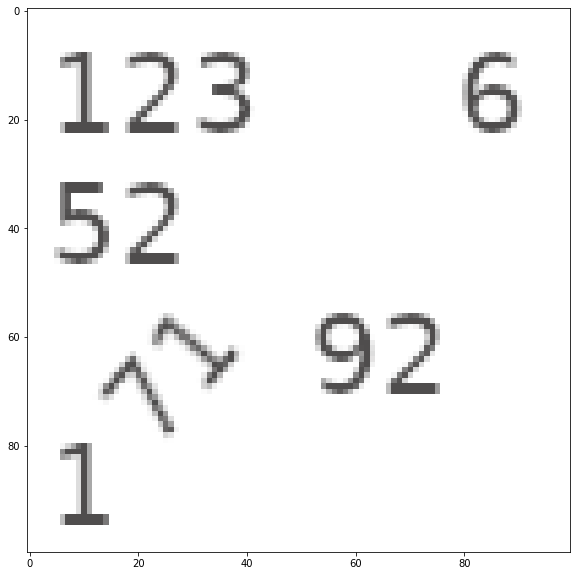

In [14]:
original = load_image("images/all-numbers.png")
show_image(original)

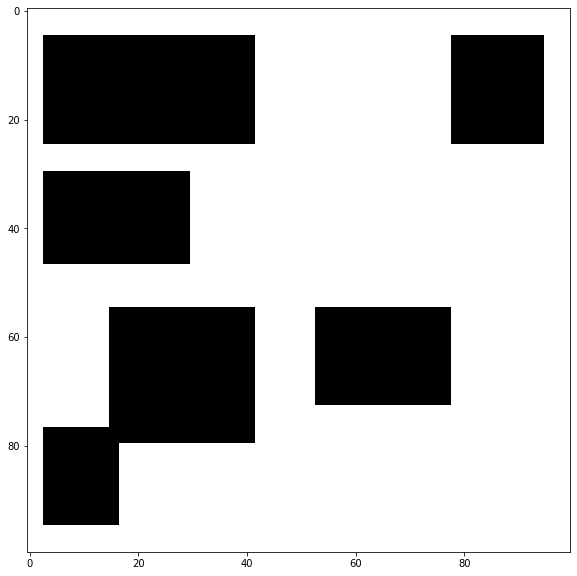

In [15]:
rectangles = [
    (
        (3, 5), (42, 25)
    ),
    (
        (78, 5), (95, 25)
    ),
    (
        (3, 30), (30, 47)
    ),
    (
        (3, 77), (17, 95)
    ),
    (
        (15, 55), (42, 80)
    ),
    (
        (53, 55), (78, 73)
    )
]
marked = create_mark(rectangles, original.shape)
show_image(marked)

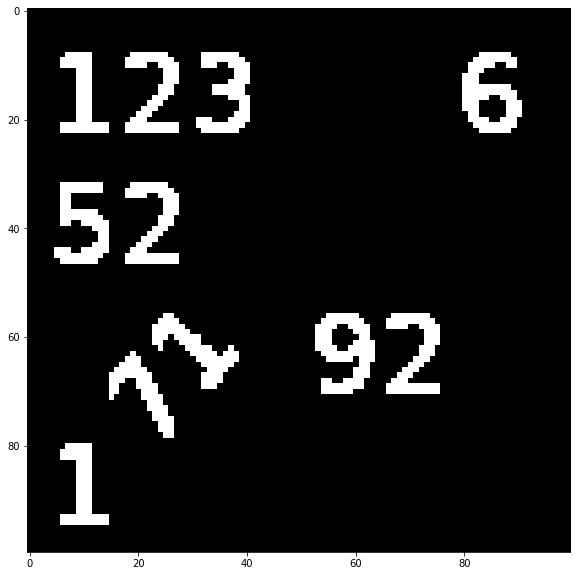

In [16]:
extracted = apply_marks(original, marked)
show_image(extracted)

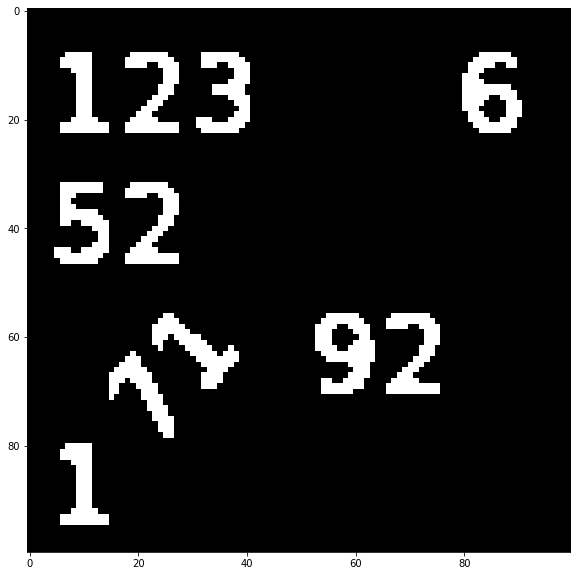

In [17]:
closed = fill_holes(extracted)
show_image(closed)

11


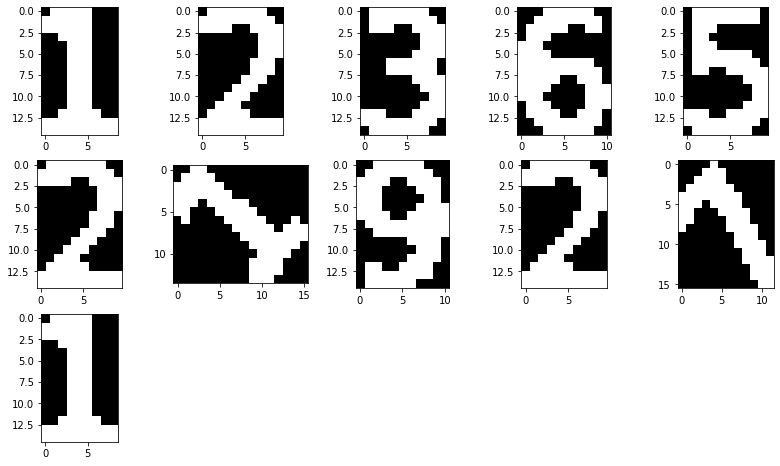

In [18]:
objects = get_objects(closed)
print(len(objects))
show_images(objects)

# With another image

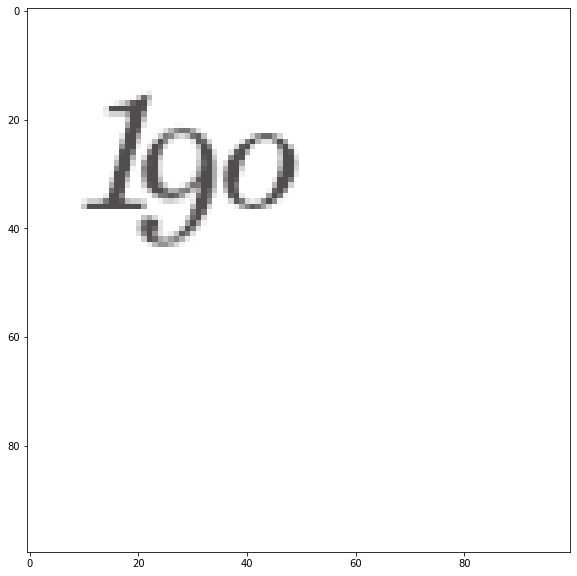

In [19]:
img2 = load_image("images/190.png")
show_image(img2)

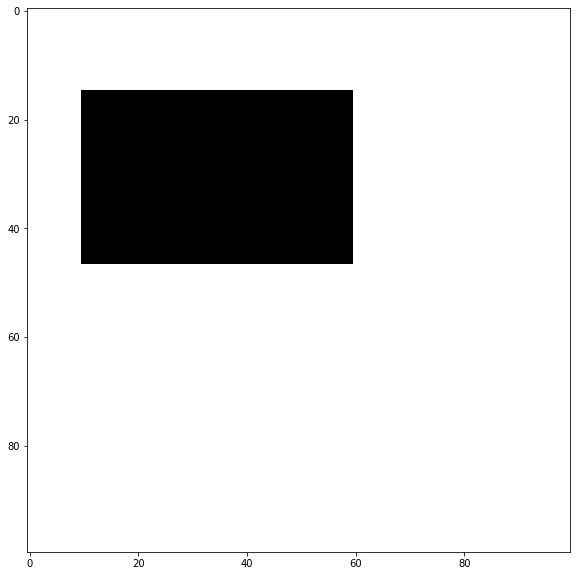

In [20]:
rectangles = [
    (
        (10, 15), (60, 47)
    )
]
marked = create_mark(rectangles, img2.shape)
show_image(marked)

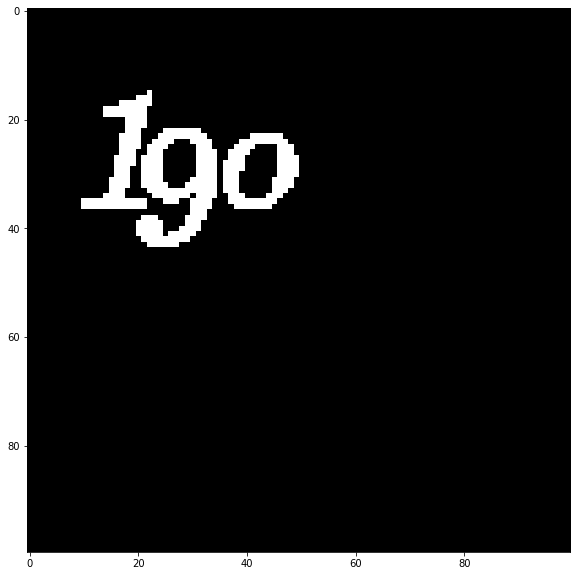

In [21]:
t = apply_marks(img2, marked)
show_image(t)

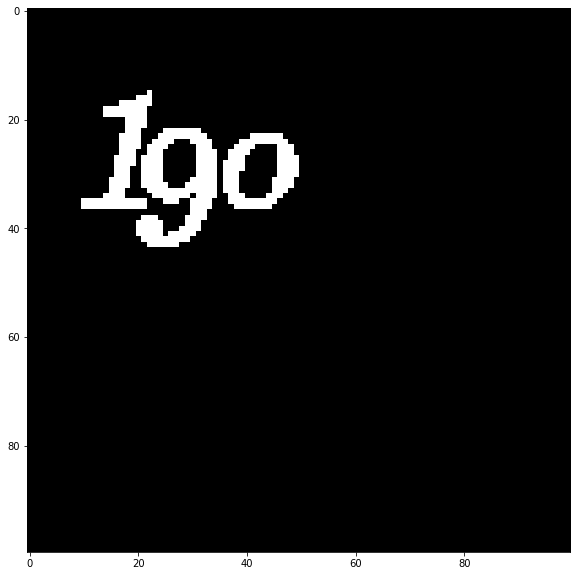

In [22]:
c = fill_holes(t, None)
show_image(c)

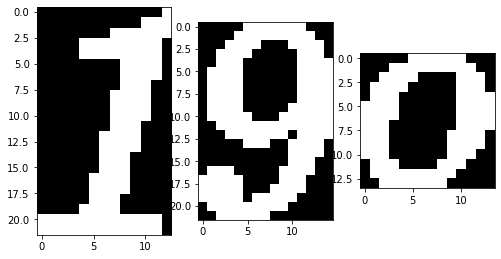

In [23]:
objects = get_objects(c)
new_objects = transpose_objects(objects)
show_images(new_objects)

# Main function

In [14]:
def process(img, marked, elt = skimage.morphology.disk(1), inversed=True, ret_props=False):
    """
    From the original image, the marks and the structural element for closure,
    return and show the resulting objects in image
    """
    extracted = img if marked is None else apply_marks(img, marked, inversed)
    closed = fill_holes(extracted, elt)
    objects, props = get_objects(closed, True)
    #new_objects = transpose_objects(objects)
    real_objects, real_props = filter_images(objects, props)
    #singles, multiples = extract_single_numbers(real_objects)
    #turned = turn_images(singles) # not necessary
    turned = real_objects
    #turned.extend(multiples)
    show_images(turned[:10])

    if ret_props:
        return turned, real_props

    return turned

# En 2 cells

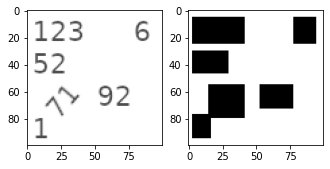

In [25]:
original = load_image("images/all-numbers.png")
rectangles = [
    (
        (3, 5), (42, 25)
    ),
    (
        (78, 5), (95, 25)
    ),
    (
        (3, 30), (30, 47)
    ),
    (
        (3, 77), (17, 95)
    ),
    (
        (15, 55), (42, 80)
    ),
    (
        (53, 55), (78, 73)
    )
]
marked = create_mark(rectangles, original.shape)
show_images([original, marked])

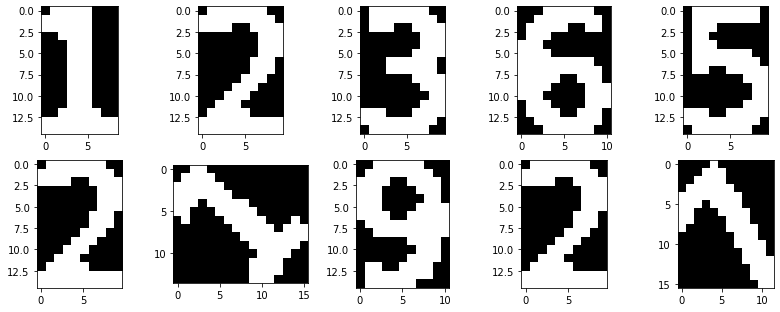

In [26]:
n1 = process(original, marked, skimage.morphology.disk(1))

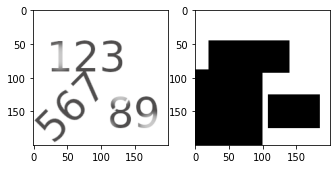

In [27]:
img2 = load_image("images/overlap-and-holes.png")
rectangles = [
    (
        (20, 45), (140, 93)
    ),
    (
        (0, 88), (100, 200)
    ),
    (
        (108, 125), (185, 175)
    )
]
marked = create_mark(rectangles, img2.shape)
show_images([img2,marked])

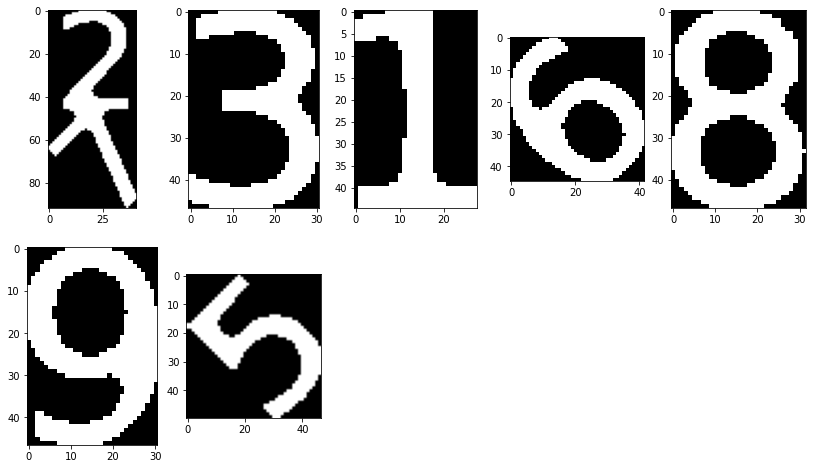

In [28]:
n2 = process(img2, marked, skimage.morphology.disk(3))

# With traits

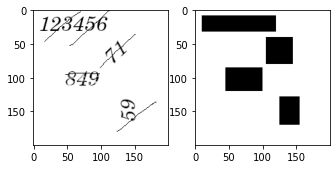

In [15]:
img3 = load_image("images/trait_rotation.png")
rectangles = [
    (
        (10, 8), (120, 32)
    ),
    (
        (105, 40), (145, 80)
    ),
    (
        (45, 85), (100, 120)
    ),
    (
        (125, 128), (155, 170)
    ),
]
marked = create_mark(rectangles, img3.shape)
show_images([img3, marked])

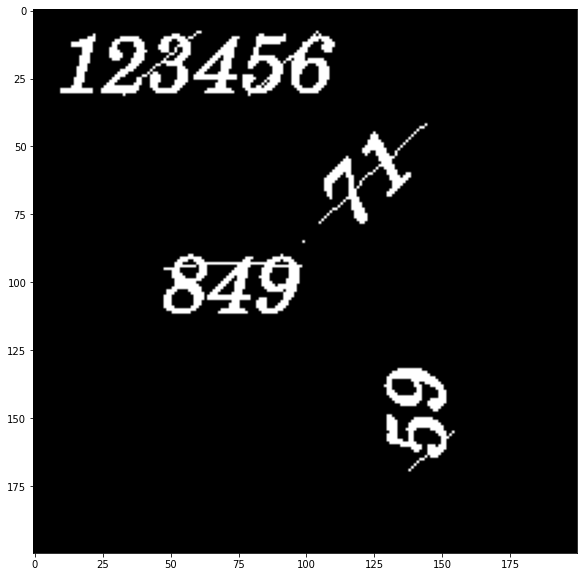

In [16]:
extracted = apply_marks(img3, marked)
show_image(extracted)

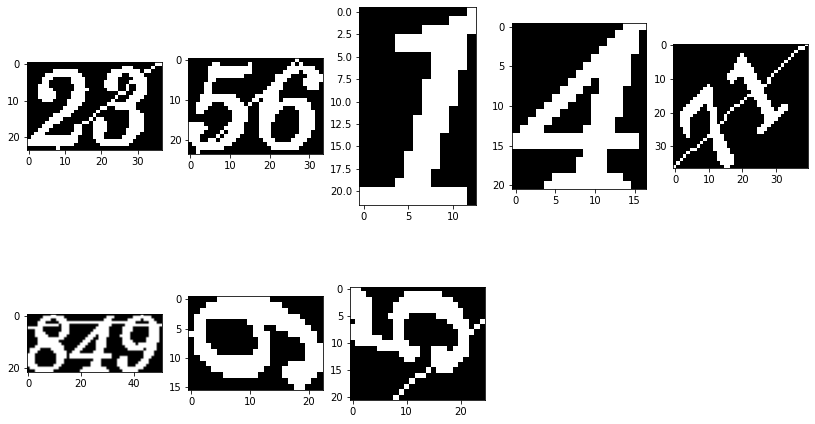

In [17]:
n3, props3 = process(img3, marked, skimage.morphology.disk(0), ret_props=True)

# With previous step output, ie my input

(315, 226, 3)


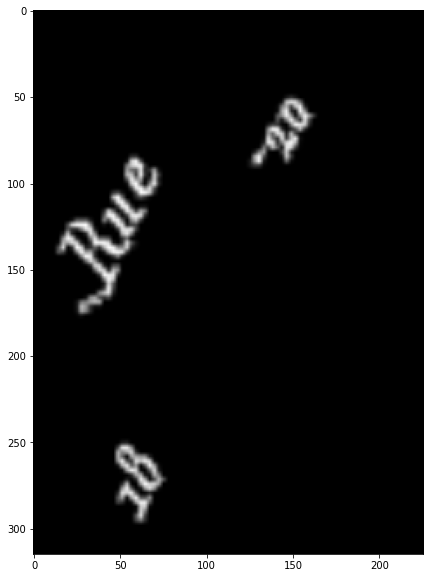

In [32]:
input_img = load_image("images/input_1.png")
show_image(input_img)
print(input_img.shape)

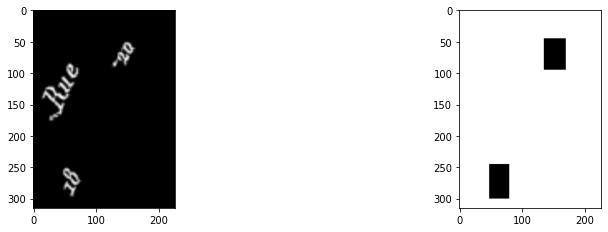

In [33]:
rectangles = [
    (
        (48, 245), (80, 300)
    ),
    (
        (135, 45), (170, 95)
    )
]
shape = (input_img.shape[0], input_img.shape[1], 4)
marked = create_mark(rectangles, shape)
show_images([input_img, marked], col=2)

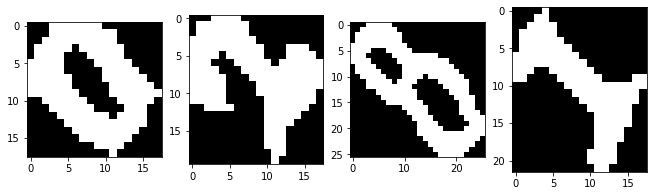

In [34]:
n4 = process(input_img, marked, skimage.morphology.disk(1), inversed=False)

(299, 334, 3)


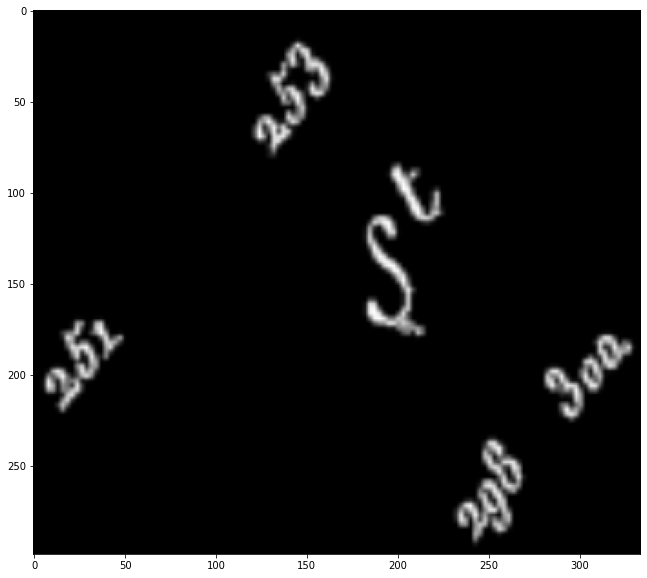

In [18]:
input_img2 = load_image("images/input_2.png")
show_image(input_img2)
print(input_img2.shape)

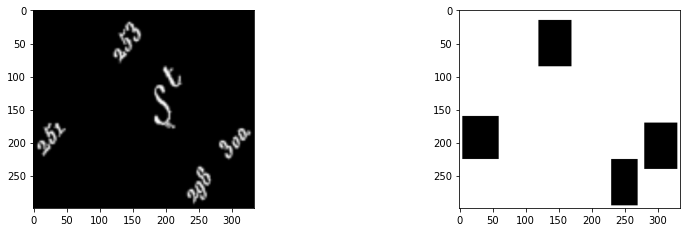

In [19]:
rectangles = [
    (
        (5, 160), (60, 225)
    ),
    (
        (120, 15), (170, 85)
    ),
    (
        (230, 225), (270, 295)
    ),
    
    (
        (280, 170), (330, 240)
    ),
]
shape = (input_img2.shape[0], input_img2.shape[1], 4)
marked5 = create_mark(rectangles, shape)
show_images([input_img2, marked5], col=2)

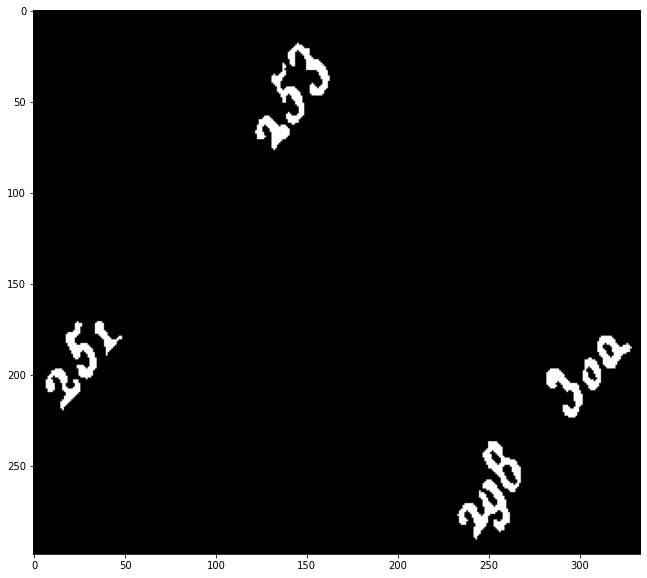

In [20]:
img = input_img2
inversed=False
elt = skimage.morphology.disk(1)
extracted = apply_marks(img, marked5, inversed)
closed = fill_holes(extracted, elt)
#show_image(extracted)
show_image(closed)

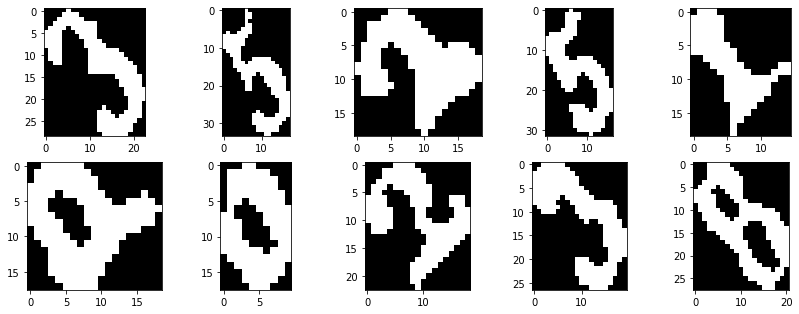

In [21]:
n5, props5 = process(input_img2, marked5, skimage.morphology.disk(1), inversed=False, ret_props=True)

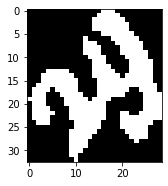

In [22]:
singles, multiples, s_p, m_p = extract_single_numbers(n5)
show_images(multiples)

# TODO:

- Gérer les overlap

In [23]:
import queue

def follow_path(original_squelette, pixel_coord):
    
    def next_cell(img, coords):
        x, y = coords
        img[y][x] = False
        cells = []
        for i in range(max(x - 1, 0), min(x + 2, img.shape[1])): # in the border of the image
            for j in range(max(y - 1, 0), min(y + 2, img.shape[0])):
                if img[j][i]:
                    cells.append((i, j))
        return cells
        
    new_sq = np.zeros(shape = original_squelette.shape, dtype=bool)
    
    next_cells = queue.Queue()
    next_cells.put(pixel_coord)
    
    while not next_cells.empty():
        cell = next_cells.get()
        new_sq[cell[1]][cell[0]] = True
        for c in next_cell(original_squelette, cell):
            next_cells.put(c)
    
    return new_sq

In [24]:
# cut a squelette into 2 squelettes
def cut(original_sq, x, y):    
    # recup les pixels objet autour du point a enlever
    object_pixels = []
    
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (i, j) == (x, y):
                continue
            
            if original_sq[j][i]:
                object_pixels.append((i, j))
            
    if len(object_pixels) != 2:
        return []
    
    original_sq[y][x] = False # set black
    
    objects = []
    for pix in object_pixels:
        objects.append(follow_path(original_sq, pix))
    
    return objects

In [25]:
# recursif ?

def multiple_to_singles(original_img):
    # un overlap
    # calcul le squelette
    skelet = skimage.morphology.skeletonize(original_img)
    
    shape = obj.shape
    # a partir du centre, sur un rectangle de 1/3 de la taille de l'image:
    possible_cut = ((shape[0] * 2 // 5, shape[1] * 2 // 5), (shape[0] * 3 // 5, shape[1] * 3 // 5)) # ((y1, x1), (y2, x2))
    print(possible_cut)
    
    for j in range(possible_cut[0][0], possible_cut[1][0]):
        for i in range(possible_cut[0][1], possible_cut[1][1]):
            
            # si un pixel noir: suivant
            if not skelet[j][i]:
                continue
                
            # sinon: essaie de couper
            copy_sq = np.copy(skelet)
            new_objs = cut(copy_sq, i, j)
            if not new_objs:
                continue
            
            # + verifie l'ordre de grandeur sur le nombre de pixels blanc du squelette dans chaque
            obj1_nb_white = np.count_nonzero(new_objs[0])
            obj2_nb_white = np.count_nonzero(new_objs[1])
            div = obj1_nb_white / obj2_nb_white 
            if div > 2 or div < 1/2:
                continue
            print(div)
            
            print(i, j)
            show_image(skelet)
            return new_objs
    
    return []

((13, 11), (19, 17))
0.6
16 18


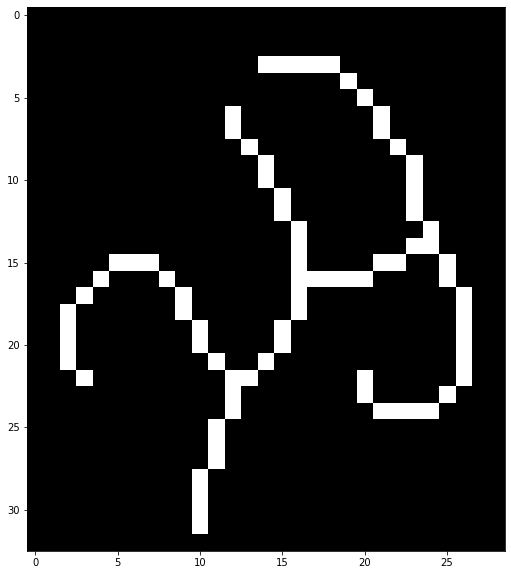

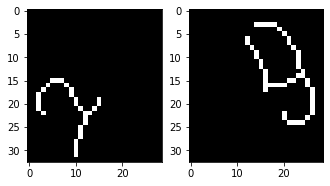

In [26]:
# get single object images and multiple object images
singles, multiples, s_p, m_p = extract_single_numbers(n5)

objects = []

# pour chaque image in multiples:
for obj in multiples:
    objects.extend(multiple_to_singles(obj))
            
show_images(objects)

# Squelette

Comment je peux découper ces nombres ?

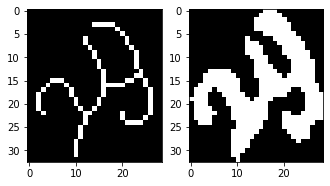

In [44]:
singles, multiples, s_p, m_p = extract_single_numbers(n5)
skelet = skimage.morphology.skeletonize(multiples[0])
show_images([skelet, multiples[0]])

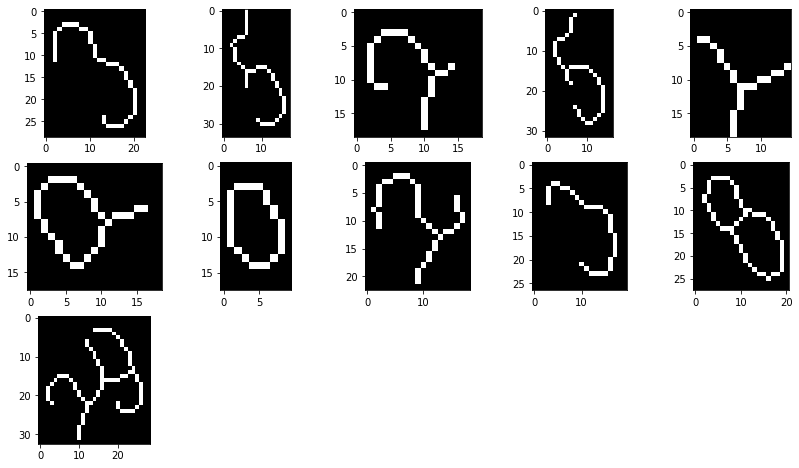

In [45]:
# show squelettes
sq = []
for obj in n5:
    sq.append(skimage.morphology.skeletonize(obj))
show_images(sq)

In [87]:
class Properties:
    """
    Create properties by hand because we can to change some attributes
    """
    def __init__(self, label, minor_axis_length, major_axis_length, orientation, corner_x, corner_y):
        self.label = label
        self.bbox = None
        self.minor_axis_length = minor_axis_length
        self.major_axis_length = major_axis_length
        self.centroid = None
        self.orientation = orientation
        
        self.corner_x = corner_x
        self.corner_y = corner_y
        
    def update_bbox(self, old):
        self.bbox = (
            old[0] + self.corner_y,
            old[1] + self.corner_x,
            old[2] + self.corner_y,
            old[3] + self.corner_x
        )
        
    def update_centroid(self, old):
        self.centroid = (
            old[0] + self.corner_y,
            old[1] + self.corner_x
        )
        

def add_result(img_res, nb_pixels, results, properties):
    """
    Add result only if good cut:
     - into 2 objects
     - good proportions
    """
    copy = np.copy(img_res)
    objects, tmp_properties = get_objects(img_res, ret_props=True)
    if len(objects) != 2: # if not 2 objects: bad cut
        return
    
    def get_proportions(new_objs):
        obj1_nb_white = np.count_nonzero(new_objs[0])
        obj2_nb_white = np.count_nonzero(new_objs[1])
        div = obj1_nb_white / obj2_nb_white 
        return div

    prop = get_proportions(objects)
    if prop <= 2 and prop >= 1/2: # good proportions
        res = {}
        # save the proportions
        res["prop"] = prop
        # save the number of cut pixels
        res["white_to_black"] = nb_pixels
        # save the results
        res["objects"] = objects
        res["image"] = copy
        
        results.append((res, properties, tmp_properties))

def pick_results(results, nb_labels):
    """
    Choose the best result:
     - less changed pixels (minimum cut)
     - best proportion if same cut
    """
    if len(results) == 0:
        print("No res to pick")
        return [], None
    
    best_res = 0
    min_cut = results[0][0]["white_to_black"]
    best_prop = results[0][0]["prop"]
    
    for i in range(1, len(results)):
        if min_cut > results[i][0]["white_to_black"] or \
         (min_cut == results[i][0]["white_to_black"] and abs(best_prop - 1) > abs(results[i][0]["prop"] - 1)):
            min_cut = results[i][0]["white_to_black"]
            best_res = i
    
    # we use in postprocess: prop.bbox, minor_axis_length, major_axis_length, centroid, orientation
    
    res, old_prop, properties = results[best_res]
    
    top_y = old_prop.bbox[0]
    top_x = old_prop.bbox[1]
    
    # label of first object in cut = same as object before cut
    new_properties1 = Properties(
        old_prop.label,
        properties[0].minor_axis_length,
        properties[0].major_axis_length,
        properties[0].orientation,
        top_x,
        top_y
    )
    # new label for the second object
    new_properties2 = Properties(
        nb_labels + 1,
        properties[1].minor_axis_length,
        properties[1].major_axis_length,
        properties[1].orientation,
        top_x,
        top_y
    )
    
    # update the bbox to global image coords
    new_properties1.update_bbox(properties[0].bbox)
    new_properties2.update_bbox(properties[1].bbox)
    
    # update the bbox to global image coords
    new_properties1.update_centroid(properties[0].centroid)
    new_properties2.update_centroid(properties[1].centroid)
    
    return res["objects"], [new_properties1, new_properties2]
        

def cut_image(original_img, prop, nb_labels):
    # un overlap
    
    height, width = original_img.shape
    # cut the object with a line
    bounds_a = (-10, 10) # orientation of the line
    bounds_b = (0, 2 * width // 3) # x axis and y axis
    
    results = []
    
    # a negative
    for a in range(bounds_a[0], 0, 1):
        origin = 0
        
        for b in range(bounds_b[0], bounds_b[1]): # top bound
            # copy the image to not modify it
            tmp = np.copy(original_img)
            
            nb_pixels = 0
            
            # draw line <=> set white pixels to black
            for x_0 in range(0, width - b):
                y = origin - a * x_0
                x = x_0 + b

                y2 = origin - (a * (x_0 + 1))

                yend = min(y2, height)

                while y < yend:
                    if tmp[y][x]:
                        tmp[y][x] = 0
                        nb_pixels += 1
                    y += 1
                
            add_result(tmp, nb_pixels, results, prop)
    
    # a positive
    for a in range(0, bounds_a[1], 1):
        origin = height - 1
        
        for b in range(bounds_b[0], bounds_b[1]): # bottom bound
            # copy the image to not modify it
            tmp = np.copy(original_img)
            
            nb_pixels = 0
            
            # draw line <=> set white pixels to black
            for x_0 in range(0, width):
                y = origin - a * x_0
                x = x_0 + b
                
                if x >= width:
                    break

                y2 = origin - a * (x_0 + 1)

                yend = max(y2, 0)

                while y > yend:
                    if not tmp[y][x]:
                        tmp[y][x] = 0
                        nb_pixels += 1
                    y -= 1
                
            add_result(tmp, nb_pixels, results, prop)
        
    return pick_results(results, nb_labels)

def multiples_to_singles(singles, original_imgs, props, m_props):
    """
    from list of single images and list of multiple images
    return all images as single number
    """
    # total nb images
    length = len(singles) + len(original_imgs)
    
    tmp = []
    tmp_props = []
    for i, img in enumerate(original_imgs):
        # try to cut
        res, res_props = cut_image(img, m_props[i], length)
        if res: # success
            tmp.extend(res)
            tmp_props.extend(res_props)
            length += 1
        else: # fail to cut
            tmp.append(img)
            tmp_props.append(m_props[i])
    
    # check ~ same shape
    height = 0
    width = 0
    for img in singles + tmp:
        height += img.shape[0]
        width += img.shape[1]
    height /= length
    width /= length
    
    while len(tmp) > 0:
        # if too large: multiple numbers
        if tmp[0].shape[0] > 1.25 * height or tmp[0].shape[1] > 1.25 * width:
            # try to cut
            res, res_props = cut_image(tmp[0], tmp_props[0], length)
            if res: # success
                tmp.extend(res)
                tmp_props.extend(res_props)
                length += 1
            else: # fail to cut
                singles.append(tmp[0])
                props.append(tmp_props[0])
                
        else:
            singles.append(tmp[0])
            props.append(tmp_props[0])
            
        # pop image from queue
        tmp = tmp[1:]
        tmp_props = tmp_props[1:]
            
    return singles, props

10 1 10 1
len res: 2
(258, 245, 287, 262) 14.777801303909344 30.08028807907144
(271.8893805309734, 253.4203539823009) 0.28345564540031726


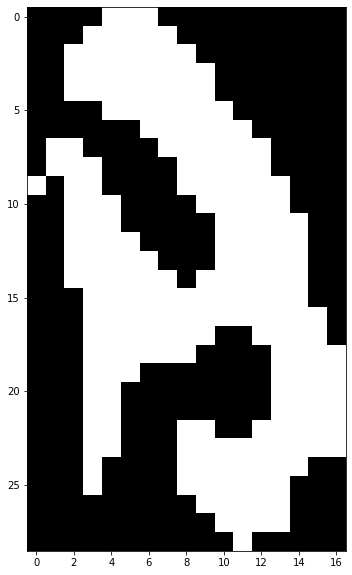

In [95]:
s5, m5, s_p, m_p = extract_single_numbers(n5, props5)
print(len(s5), len(m5), len(s_p), len(m_p))
res, props = cut_image(m5[0], m_p[0], len(s_p) + len(m_p) + 1)
print("len res:", len(res))
show_image(res[0])
#show_images(res)
print(props[0].bbox, props[0].minor_axis_length, props[0].major_axis_length)
print(props[0].centroid, props[0].orientation)

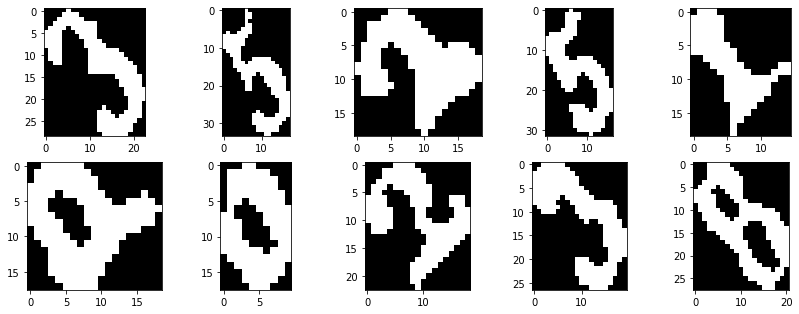

multiples:


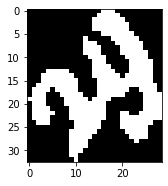

result images


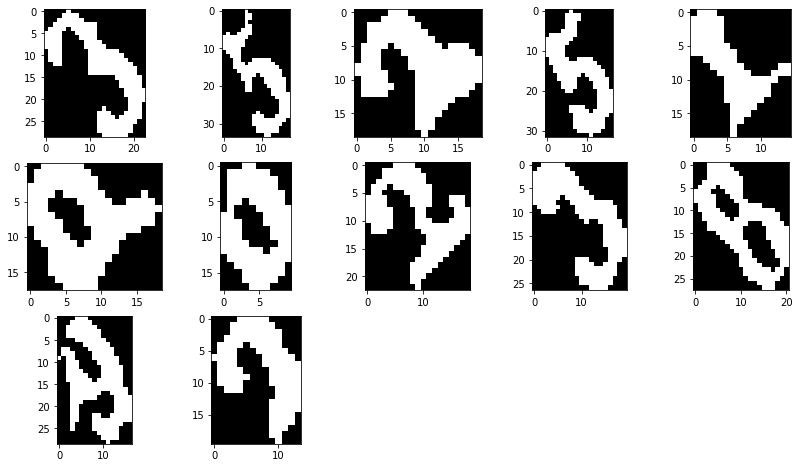

12 12


In [96]:
n5, props5 = process(input_img2, marked5, skimage.morphology.disk(1), inversed=False, ret_props=True)
s5, m5, s_p, m_p = extract_single_numbers(n5, props5)
print("multiples:")
show_images(m5)
images, props = multiples_to_singles(s5, m5, s_p, m_p)
print("result images")
show_images(images)
print(len(images), len(props))

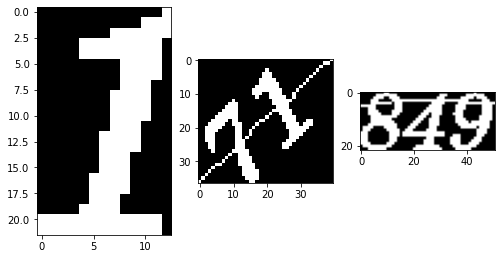

No res to pick


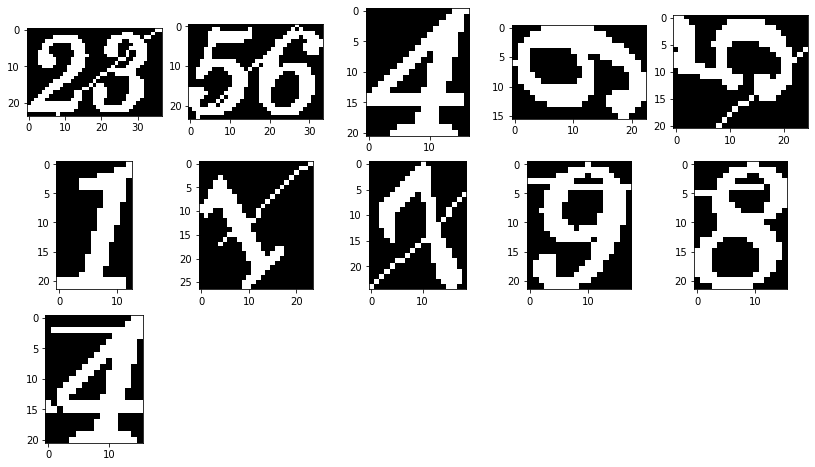

In [97]:
s3, m3, s_p, m_p = extract_single_numbers(n3, props3)
show_images(m3)
singles, props = multiples_to_singles(s3, m3, s_p, m_p)
show_images(singles)

## Pipeline

In [50]:
import skimage.color
import json

def props_to_dict(props):
    return {
        'bbox': props.bbox,
        'minor_axis_length': props.minor_axis_length,
        'major_axis_length': props.major_axis_length,
        'centroid': props.centroid,
        'orientation': props.orientation,
    }

def process_from_heatmaps(inputFile, outputFile):
    heatmap = load_image(inputFile)
    
    rectangles = create_rectangles_from_heatmap(heatmap)

    images, props = process(heatmap, None, ret_props=True)
    singles, multiples, single_props, multiple_props = extract_single_numbers(images, props)
    res_images, props = multiple_to_singles2(singles, multiples, single_props, multiple_props)

    import os
    os.makedirs(outputFile, exist_ok=True)

    for i, image in enumerate(images):
        with open('os.path.join(outputFile, f"{i:04}.json")', 'w') as f:
            json.dump(props_to_dict(props[i]), f)
        skimage.io.imsave(os.path.join(outputFile, f"{i:04}.png"), image.astype(np.uint8)*255)

In [51]:
#process_from_heatmaps("output_dir/03_heatmaps.png", "results")